# Михайлов Даниил. Анализ Данных

Структура файла:
    
    Предобработка данных:
        * Построение графиков распределения
        * Устранение выбросов:
            * IQR
            * По квантилям
        * Построение карты корреляций:
            * Рассмотрение варианта с отбрасыванием высококоррелированных значений и их оставлением
        * Заполнение пропусков:
            * Медианным значением
            * Средним значением
        * Стандартизациях данных (для метрических алгоритмов)
        
    Простые модели:
        * Логистическая регрессия:
            * Нахождение коэффициентов
            * Метрики качества
            * Зависимость точность от количества фолдов в кросс валидации
        * Single Decision Tree:
            * Определение гиперпараметров с помощью кросс валидации
            * Визуализация дерева
            * Метрики качества
        * kNN:
            * Стандартизация данных
            * Кросс валидация (Elbow method) для определения количества соседей
            * Метрики качества
            
    Ансамбли:
        * Градиентный бустинг на деревьях:
            * Кросс валидация для поиска гиперпараметров
            * Байесовская оптимизация
            * Метрики качества
            * Визуализация дерева
            
    Сравнение моделей:
        * Построение графиков метрик
        * Сравнение разных метрик
        * Объяснение результатов

In [307]:
import pandas as pd
import seaborn as sns

from sklearn import decomposition

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
from sklearn import tree

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import cv
from xgboost import plot_tree

from sklearn import metrics

import numpy as np
from scipy import stats

from sklearn.model_selection import cross_val_score

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import statsmodels.formula.api as smf
import statsmodels.api as sm

from dtreeviz.trees import dtreeviz

from sklearn.model_selection import KFold

import matplotlib as mpl

from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

In [47]:
np.random.seed(1)

In [116]:
X = pd.read_csv("./input/X_train.csv", sep = ",")
y = pd.read_csv("./input/y_train.csv", sep = ";")

In [117]:
X["target"] = y

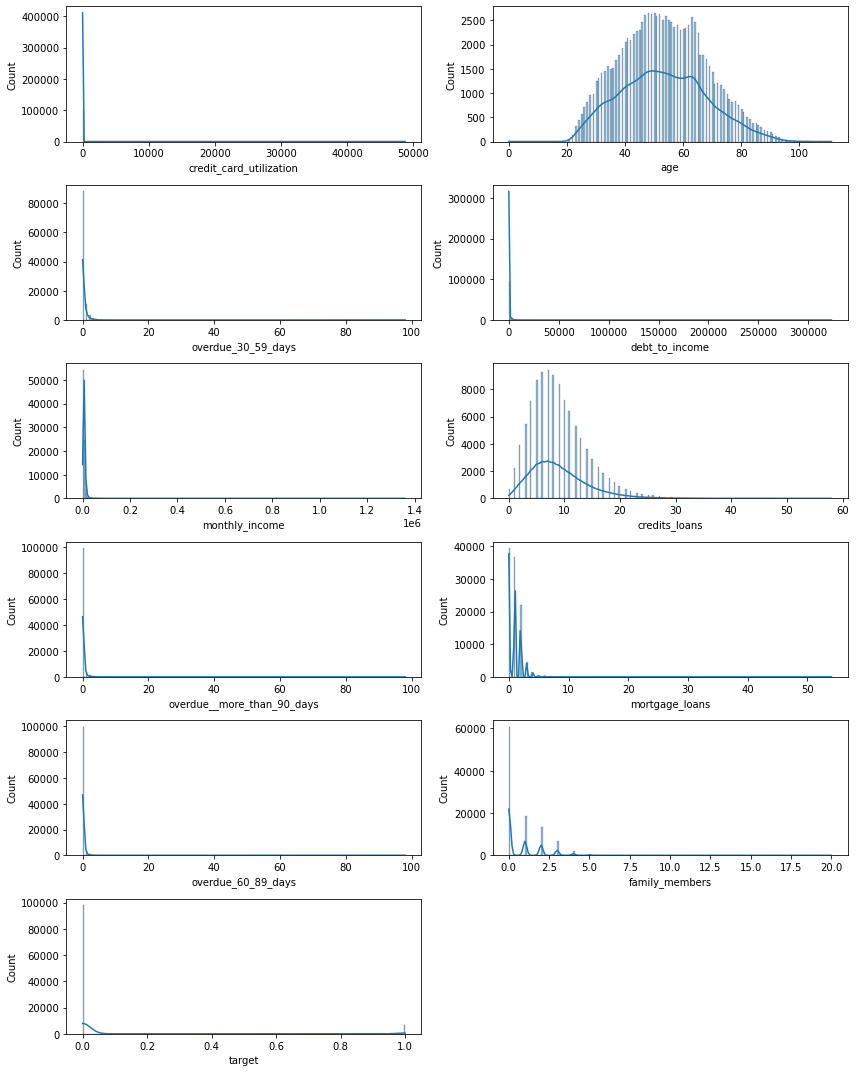

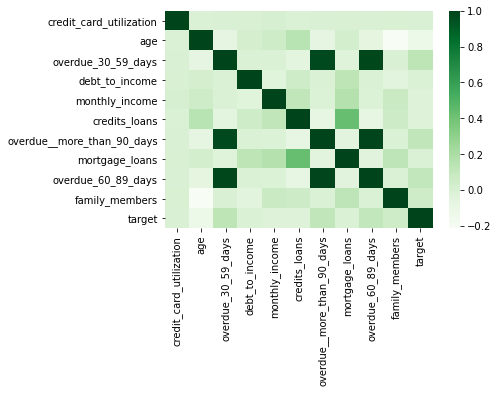

In [92]:
plt.figure(figsize=(12, 15))

for i, column_name in enumerate(X.columns):
    plt.subplot(6,2,i+1)
    sns.histplot(X[column_name], bins=200, kde=True)
plt.tight_layout()
plt.show()


sns.heatmap(X.corr(), annot=False, cmap="Greens")
plt.show()

### Как видим, параметры распределены достаточно плохо.
* Многие из них имеют слишком сильный перевес в сторону нулевого значения
* Есть пропущенные значения
* overdue_30_59_days, overdue_60_89_days, overdue__more_than_90_days  - высоко коррелированы
* target сильнее всего коррелирован с overdue_30_59_days и почти не зависит от остальных переменных

это всё то, что нужно точно учесть при первичной предобработке

## Первичная предобработка

### Работа с выбросами
Для нахождения выбросов использовался также метод [IQR](https://en.wikipedia.org/wiki/Interquartile_range) (код в комментарии ниже), однако, как оказалось после тетсов, обычное удаление выбросов по квантилям, дает не меньшие результаты в итоговой точности

In [ ]:
def find_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.85) - df[variable].quantile(0.15)
    lower_boundary = df[variable].quantile(0.15) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.85) + (IQR * distance)
    return upper_boundary, lower_boundary

#for variable in columns:
    #upper_boundary, lower_boundary = find_boundaries(X, variable, 1.5)
    #X = X.loc[(X[variable] >= lower_boundary) & (X[variable] <= upper_boundary)].reset_index(drop = True)

Отбрасывание по квантилям (используемый метод)

In [106]:
for column_name in ['credit_card_utilization','overdue_30_59_days', 'overdue_60_89_days', 'overdue__more_than_90_days', 'debt_to_income', 'monthly_income']:
    q_low = X[column_name].quantile(0.005)
    q_high = X[column_name].quantile(0.995)
    
    X_f = X[(X[column_name] < q_high) & (X[column_name] > q_low)]
    
X_f = X_f.reset_index(drop = True)
print(len(X_f))

82534


In [107]:
for column_name in ['credit_card_utilization', 'overdue_30_59_days', 'overdue_60_89_days', 'overdue__more_than_90_days', 'debt_to_income']:
    q_low = X_f[column_name].quantile(0.005)
    q_high = X_f[column_name].quantile(0.995)
    
    X_f = X_f[(X_f[column_name] <=q_high) & (X_f[column_name] >= q_low)]
    
X_f = X_f.reset_index(drop = True)
print(len(X_f))

80950


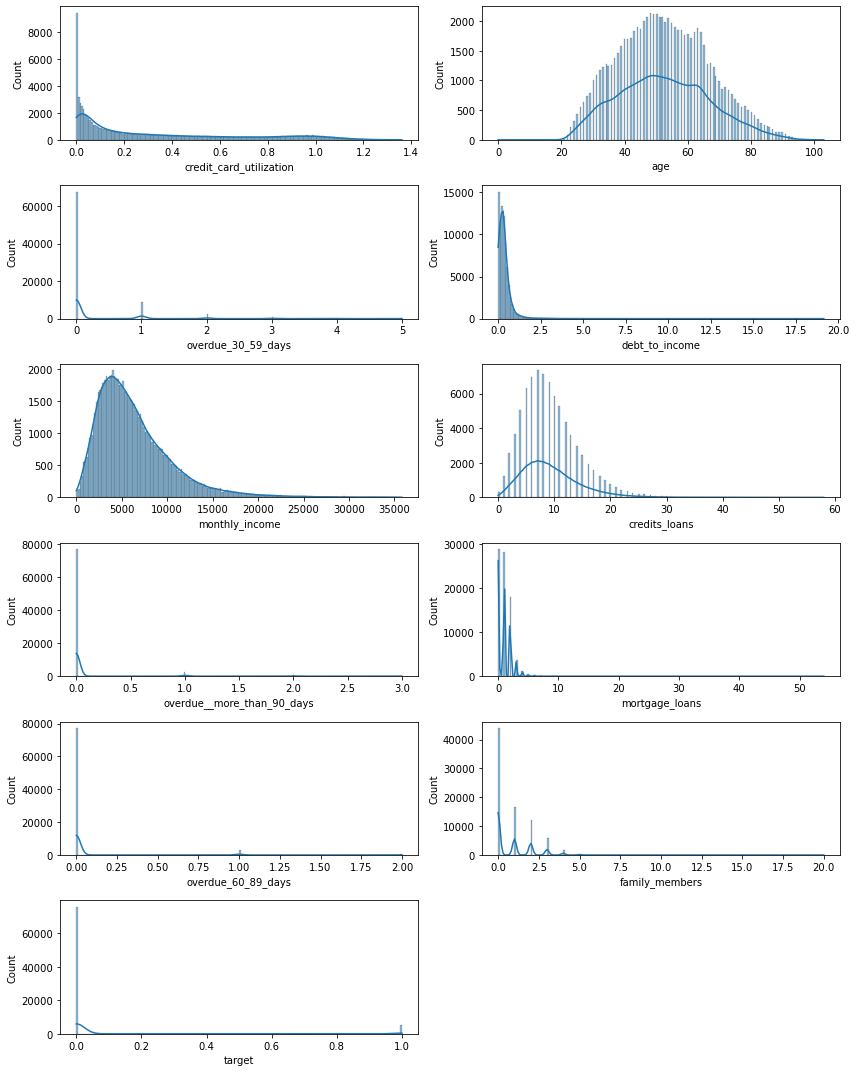

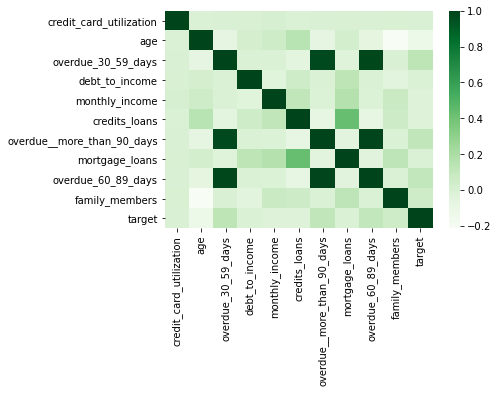

In [110]:
plt.figure(figsize=(12, 15))

for i, column_name in enumerate(X_f.columns):
    plt.subplot(6,2,i+1)
    sns.histplot(X_f[column_name], bins=200, kde=True)
plt.tight_layout()
plt.show()

sns.heatmap(X.corr(), annot=False, cmap="Greens")
plt.show()

### Заполнение пропусков 
Несмотря на проведенную предобработку по выбросам, мы могли что-то не заметить. Поэтому более аккуратным выглядит заполнение пропусков медианным значением, однако, оказалось, что это не сказывается на итоговой точности

In [118]:
X_f = X_f.fillna(X_f.mean())
#X_f = X_f.fillna(X_f.median())

### Удаление высококоррелированных значений
Влияет на точность не во всех алгоритмах, поэтому будем использовать не везде

In [119]:
# X_f.drop(columns = ["overdue__more_than_90_days", 'overdue_60_89_days'], inplace = True)

# Простые модели

In [214]:
y_f = X_f.pop("target")

X_train,X_test,y_train,y_test = train_test_split(X_f,y_f,test_size=0.25,random_state=0)

In [199]:
# https://www.kaggle.com/code/gauravduttakiit/hyperparameter-tuning-in-decision-trees
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))
    
    
def get_dt_graph(dt_classifier):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt_classifier,
                       feature_names=X.columns,
                       class_names=['0', "1"],
                       filled=True)

### Логистическая регрессия

In [124]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)

In [131]:
logreg_proba = log_reg.predict_proba(X_test)[:,1]

In [274]:
logreg_pred = log_reg.predict(X_test)

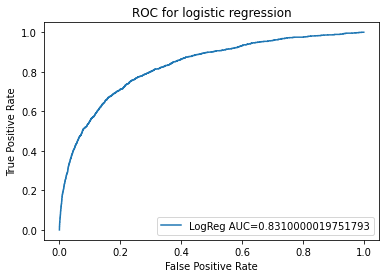

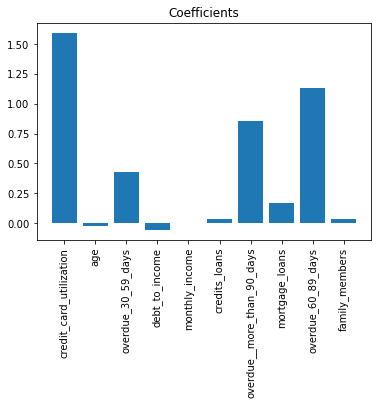

In [308]:
fpr, tpr, _ = metrics.roc_curve(y_test,  logreg_proba)
auc = metrics.roc_auc_score(y_test, logreg_proba)

plt.plot(fpr,tpr,label="LogReg AUC="+str(auc))
plt.title("ROC for logistic regression")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


importance = log_reg.coef_[0]
    
plt.bar(list(X_test.columns), importance)
plt.title("Coefficients")
plt.tick_params(axis='x', labelrotation=90)
plt.show()

In [243]:
evaluate_model(log_reg)

Train Accuracy : 0.937705890104098
Train Confusion Matrix:
[[56371   439]
 [ 3343   559]]
--------------------------------------------------
Test Accuracy : 0.9386797114339361
Test Confusion Matrix:
[[18817   139]
 [ 1102   180]]


##### рассмотрим зависимость точности логистической регрессии от количества Fold-ов

In [147]:
lm = LogisticRegression(solver='lbfgs', max_iter=1000)

In [158]:
score_folds = []
for i in tqdm(list(range(2, 11))):
    folds = KFold(n_splits = i, shuffle = True, random_state = 1)
    scores = cross_val_score(lm, X_train, y_train, scoring='roc_auc', cv=folds)
    score_folds.append(scores.mean())

  0%|          | 0/9 [00:00<?, ?it/s]

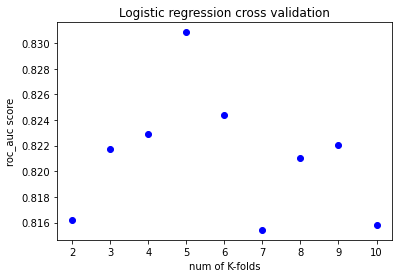

In [160]:
plt.scatter(list(range(2, 11)), score_folds, c ="blue")
plt.title("Logistic regression cross validation")
plt.xlabel("num of K-folds")
plt.ylabel("roc_auc score")
plt.show()

### Decision tree
Сразу же проведем кросс-валидацию по необходимым параметрам

Воспользуемся двумя параметрами: критерий (Джини или Энтропия) и максимальная глубина дерева. Подбирать большее количество не требуется, так как в итоговое решение DecisionTree все равно не войдет - оно точно будет доминироваться каким-либо ансамблем, построенным на деревьях

In [179]:
dec_tree = tree.DecisionTreeClassifier()

In [189]:
params = {
    'max_depth': list(range(2, 24, 2)),
    'criterion': ["gini", "entropy"]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [192]:
clf_GS = GridSearchCV(estimator=dec_tree, 
                           param_grid=params, 
                           cv=kfold, n_jobs=-1, verbose=1, scoring = "accuracy")

In [193]:
clf_GS.fit(X_train, y_train)

Fitting 3 folds for each of 22 candidates, totalling 66 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]},
             scoring='accuracy', verbose=1)

In [195]:
clf_GS.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [270]:
clf_pred = clf_GS.best_estimator_.predict(X_test)

In [203]:
evaluate_model(clf_GS.best_estimator_)

Train Accuracy : 0.9373270523125576
Train Confusion Matrix:
[[56352   458]
 [ 3347   555]]
--------------------------------------------------
Test Accuracy : 0.9384820634450044
Test Confusion Matrix:
[[18800   156]
 [ 1089   193]]


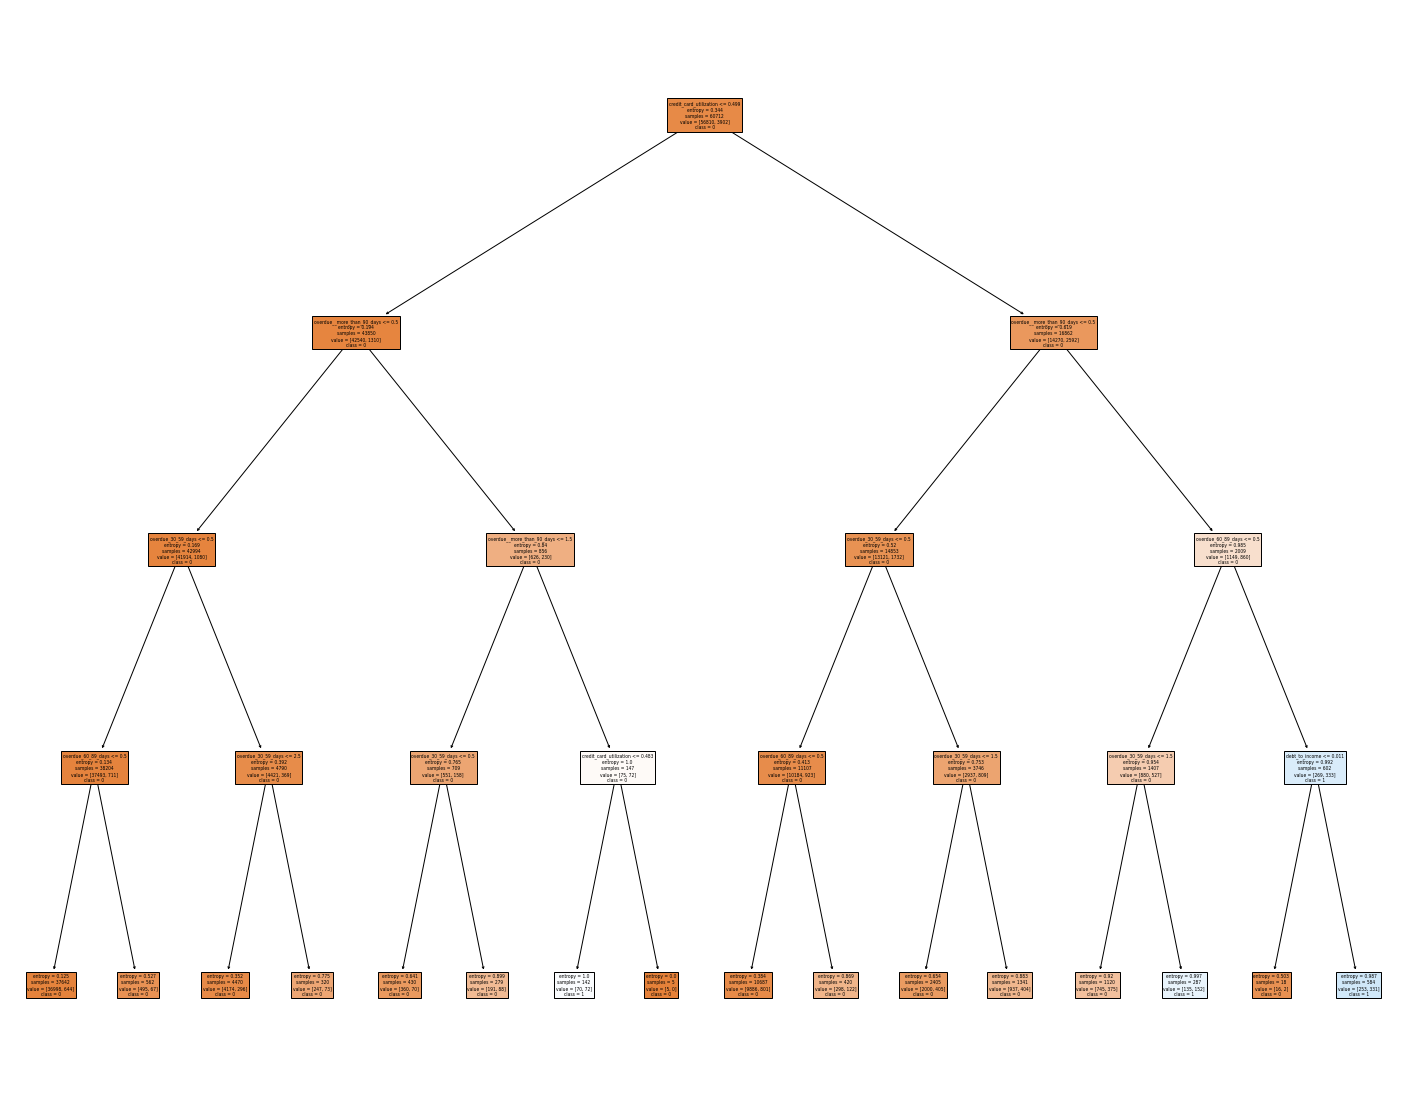

In [204]:
get_dt_graph(clf_GS.best_estimator_)

### kNN
https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
Для использования этого алгоритма нам потребуется изначально привести переменные к нормальному виду.

Это необходимо сделать, потому что kNN явлется метрическим алгоритмом, и расстояния по разным переменным должны в каком-то смысле быть сравнимыми

In [215]:
std = StandardScaler()

X_train_scaled = std.fit_transform(X_train)
X_test_scaled = std.transform(X_test)

In [210]:
knn = KNeighborsClassifier()

In [217]:
param_grid = {"n_neighbors": list(range(2, 30, 2))}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

knn_gscv = GridSearchCV(estimator = knn, param_grid = param_grid, cv=kfold)

In [218]:
knn_gscv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                         24, 26, 28]})

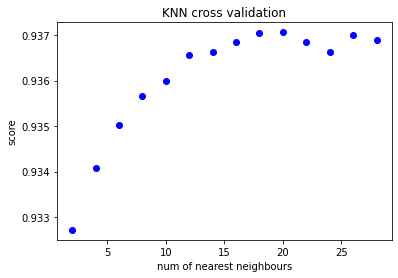

In [224]:
plt.scatter(list(range(2, 30, 2)), knn_gscv.cv_results_["mean_test_score"], c ="blue")
plt.title("KNN cross validation")
plt.xlabel("num of nearest neighbours")
plt.ylabel("score")
plt.show()

Для определения оптимального количества соседей можем воспользоваться либо лучшим результатом кросс-валидации, либо Elbow method. В данном случае, они дают одинаковый результат

In [232]:
knn_proba = knn_gscv.best_estimator_.predict_proba(X_test_scaled)[:,1]

In [269]:
knn_pred = knn_gscv.best_estimator_.predict(X_test_scaled)

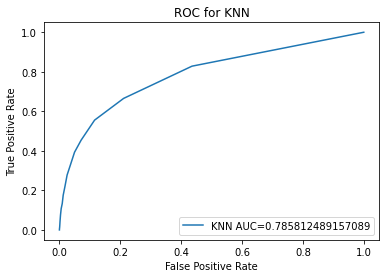

In [233]:
fpr, tpr, _ = metrics.roc_curve(y_test,  knn_proba)
auc = metrics.roc_auc_score(y_test, knn_proba)

plt.plot(fpr,tpr,label="KNN AUC="+str(auc))
plt.title("ROC for KNN")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Ансамбли

### В качестве более сложной модели воспользуемся градиентным бустингом на деревьях в реализации xgboost

Подбор гиперпараметров проведем с использованием [Байесовской оптимизации](https://ru.wikipedia.org/wiki/Оптимизация_гиперпараметров)


In [235]:
# Bayesian optimization

space = {
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1, 1]),
    'max_depth': hp.choice('max_depth', range(3, 25, 3)),
    'gamma': hp.choice('gamma', [i/10 for i in range(0,5)]),
    'colsample_bytree': hp.choice('colsample_bytree', [i/10 for i in range(1,10)]),
    'reg_alpha': hp.choice('reg_alpha', [0.1, 1, 4, 7, 10, 15, 20]),
    'reg_lambda': hp.choice('reg_lambda', [0.005, 0.01, 0.03, 0.07, 0.1, 1])
}


kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

def objective(params):
    
    xgboost = XGBClassifier(seed=0, **params)
    scores = cross_val_score(xgboost, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=0)
    
    best_score = max(scores)
    loss = - best_score
    
    return({'loss': loss, 'params': params, "status": STATUS_OK})

bayes_trials = Trials()

best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

100%|████████████████████████████████████████████████| 48/48 [02:36<00:00,  3.26s/trial, best loss: -0.847100121455352]


In [236]:
space_eval(space, best)

{'colsample_bytree': 0.4,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 6,
 'reg_alpha': 10,
 'reg_lambda': 0.005}

In [237]:
xgboost_bo = XGBClassifier(seed=1, colsample_bytree=0.4, gamma= 0.4, learning_rate= 0.1,
                           max_depth= 6, reg_alpha= 10, reg_lambda= 0.005).fit(X_train, y_train)

C:\Users\dmih0\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [239]:
xgb_proba = xgboost_bo.predict_proba(X_test)[:,1]
xgb_pred = xgboost_bo.predict(X_test)

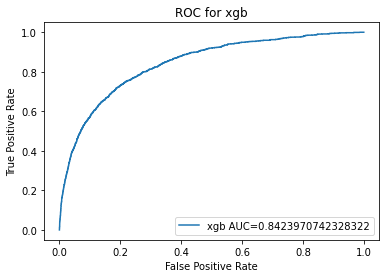

In [241]:
fpr, tpr, _ = metrics.roc_curve(y_test,  xgb_proba)
auc = metrics.roc_auc_score(y_test, xgb_proba)

plt.plot(fpr,tpr,label="xgb AUC="+str(auc))
plt.title("ROC for xgb")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [242]:
evaluate_model(xgboost_bo)

Train Accuracy : 0.9394518381868494
Train Confusion Matrix:
[[56477   333]
 [ 3343   559]]
--------------------------------------------------
Test Accuracy : 0.939470303389663
Test Confusion Matrix:
[[18837   119]
 [ 1106   176]]


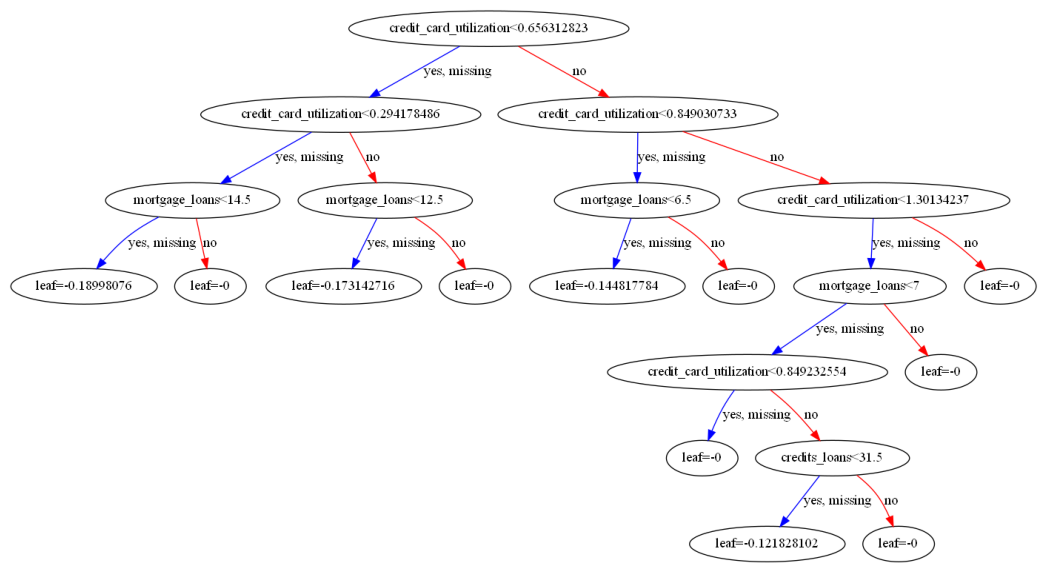

In [258]:
plot_tree(xgboost_bo)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

# Сравнение моделей

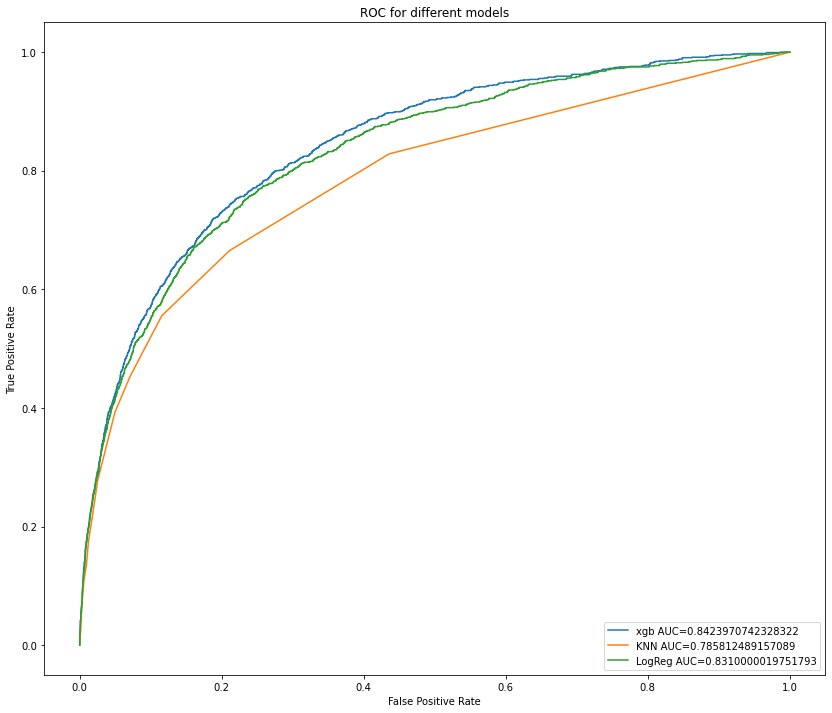

In [262]:
plt.figure(figsize=(14, 12))
plt.title("ROC for different models")

fpr, tpr, _ = metrics.roc_curve(y_test,  xgb_proba)
auc = metrics.roc_auc_score(y_test, xgb_proba)
plt.plot(fpr,tpr,label="xgb AUC="+str(auc))


fpr, tpr, _ = metrics.roc_curve(y_test,  knn_proba)
auc = metrics.roc_auc_score(y_test, knn_proba)
plt.plot(fpr,tpr,label="KNN AUC="+str(auc))


fpr, tpr, _ = metrics.roc_curve(y_test,  logreg_proba)
auc = metrics.roc_auc_score(y_test, logreg_proba)
plt.plot(fpr,tpr,label="LogReg AUC="+str(auc))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [305]:
def pres(pred):
    return(str(round(precision_score(y_test, pred), 2)))

def rec(pred):
    return(str(round(recall_score(y_test, pred), 2)))

def acc(pred):
    return(str(round(accuracy_score(y_test, pred), 2)))

def f1(pred):
    return(str(round(f1_score(y_test, pred), 2)))

def auc(pred):
    return(str(round(roc_auc_score(y_test, pred), 2)))

print("       accurancy   precision   recall     f1")
print(f"logreg   {acc(logreg_pred)}         {pres(logreg_pred)}      {rec(logreg_pred)}      {f1(logreg_pred)}")
print(f"dectree   {acc(clf_pred)}         {pres(clf_pred)}      {rec(clf_pred)}      {f1(clf_pred)}")
print(f"KNN      {acc(knn_pred)}         {pres(knn_pred)}      {rec(knn_pred)}      {f1(knn_pred)}")
print(f"xgboost   {acc(xgb_pred)}         {pres(xgb_pred)}      {rec(xgb_pred)}      {f1(xgb_pred)}")

       accurancy   precision   recall     f1
logreg   0.94         0.56      0.14      0.22
dectree   0.94         0.55      0.15      0.24
KNN      0.94         0.56      0.11      0.18
xgboost   0.94         0.6      0.14      0.22


#### Заметим, что в получившихся результатах, значение accuracy совпадает. Это связано с тем, что предсказываемсые классы в выборке не сбалансированы. И в случае данной метрики, мы могли бы просто дать предсказание константой 0 и получить такую же точность.
#### Поэтому этот критерий не является информативным в нашей ситуации.
#### Что касается остальных показателей, они все довольно близки, но, что интересно, single Decision tree имеет более высокие показатели, чем ансамбль деревьев.
#### Вероятнее всего, это связано с тем, что в градиентном бустинге мы максимизировали roc auc и в какой-то степени переобучились под данный показатель.

#### Если рассмотреть нашу главную метрику качества - ROC AUC, то градиентный бустинг дает нам наивысшую точность, но очень близко к нему находится логистическая регрессия

### В качестве финальной модели мною был выбран градиентный бустинг. Однако, можно было бы попробовать совместить его с логистической регрессией для улучшения результатов